# <p style="text-align: center;">Capstone Project - Early Fusion 1a - Tabular + Images (ENet) + Old Notes</p>

## Introduction

### Approach

In this version (1) of the code, 

* Section 2 deals with data input
* Section 3 provides the necessary data preparation
* Section 4 sets the initial model parameters 
* Section 5 train & tunes the model
* Section 6 deals with testing
* Section 7 Miscellaneous 

### Literature Review

None

## Input Data

### Packages & Methods

In [1]:
#!pip install xgboost

In [2]:
#Start importing
import numpy as np
from numpy import *
import pandas as pd
from pandas import DataFrame
from pandas import Series
from copy import deepcopy
import gzip
import os
import json
import re
import datetime as dt
import pprint
pd.options.display.max_columns = 999
from collections import Counter
import sys
from contextlib import contextmanager

import seaborn as sns
sns.set(style="darkgrid")  # default style
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import matplotlib
import matplotlib.tri as tri
plt.rcParams['contour.negative_linestyle']='solid'  # to force negative contours to have solid lines
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 10,10
import plotly.graph_objects as go

import sweetviz as sv

from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale,StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, average_precision_score, log_loss

#models
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier

import joblib
import pickle

RANDOM_SEED = 711                       # Set a random seed for reproducibility!

### Read data from input files

In [3]:
# Base directories/files
local_base_dir = '/tf/mount/0 Berkeley/0 Spring 2024/w210 Capstone/Project/Notebooks'
img_subdir = 'Output_for_EF_Models/output_4-1-24'
scenario = '4_bal_s'

In [4]:
# Stored Tabular Input data files
X_train_tab_inp_file = local_base_dir + '/' + 'X_train_4_bal_s.csv'
y_train_tab_inp_file = local_base_dir + '/' + 'y_train_4_bal_s.csv'
X_val_tab_inp_file = local_base_dir + '/' + 'X_val_4_bal_s.csv'
y_val_tab_inp_file = local_base_dir + '/' + 'y_val_4_bal_s.csv'
X_test_tab_inp_file = local_base_dir + '/' + 'X_test_4_bal_s.csv'
y_test_tab_inp_file = local_base_dir + '/' + 'y_test_4_bal_s.csv'

train_tabular_prob_inp_file = local_base_dir + '/' + 'tabular_train_class_probabilities.csv'
val_tabular_prob_inp_file   = local_base_dir + '/' + 'tabular_validate_class_probabilities.csv'
test_tabular_prob_inp_file  = local_base_dir + '/' + 'tabular_test_class_probabilities.csv'

In [5]:
# Stored Image Input data files
train_image_prob_inp_file = os.path.join(local_base_dir,img_subdir,'Apr_1_ENet_train_bal_prob.csv')
val_image_prob_inp_file   = os.path.join(local_base_dir,img_subdir,'Apr_1_ENet_val_prob.csv')
test_image_prob_inp_file  = os.path.join(local_base_dir,img_subdir,'Apr_1_ENet_test_prob.csv')

In [6]:
# Stored text Input data files
text_old_model_prob_inp_file = local_base_dir + '/' + 'NLP_Old_model_31032024_train_valid_test_results.csv' #Old model

In [7]:
# Load stored tabular (t) input data
X_train_t = pd.read_csv(X_train_tab_inp_file, index_col='patient_id')
y_train_t = pd.read_csv(y_train_tab_inp_file, index_col='patient_id')
X_val_t = pd.read_csv(X_val_tab_inp_file, index_col='patient_id')
y_val_t = pd.read_csv(y_val_tab_inp_file, index_col='patient_id')
X_test_t = pd.read_csv(X_test_tab_inp_file, index_col='patient_id')
y_test_t = pd.read_csv(y_test_tab_inp_file, index_col='patient_id')

X_train_prob_t = pd.read_csv(train_tabular_prob_inp_file, index_col='patient_id')
X_test_prob_t = pd.read_csv(test_tabular_prob_inp_file, index_col='patient_id')

Check unique values in X_test vs X_train (this was done due to an error in later steps)

In [8]:
# Had erros when testing. It looks like X_test['acuity'] has '5' which did not exist in train data 
print(X_train_t['pain'].unique())
print(X_train_t['acuity'].unique())
print(X_test_t['pain'].unique())
print(X_test_t['acuity'].unique())

[ 0 10  9  8  7  4  6  5  1  3  2]
[2 3 1 4]
[ 8  0 10  5  3  4  2  1  6  7  9]
[1 2 3 4 5]


In [9]:
# Check the number of records with '5' in the 'acuity' column
num_records_with_5 = X_test_t[X_test_t['acuity'] == 5].shape[0]
print(f"Number of records with '5' in the 'acuity' column: {num_records_with_5}")

Number of records with '5' in the 'acuity' column: 1


In [10]:
# Remove that record since it is only 1

# Filter out records where 'acuity' is 5
X_test_t = X_test_t[X_test_t['acuity'] != 5]
y_test_t = y_test_t.loc[X_test_t.index]

# Verify the filtering
print(f"Shape of X_test_t after filtering: {X_test_t.shape}")
print(f"Shape of y_test_t after filtering: {y_test_t.shape}")

Shape of X_test_t after filtering: (1910, 8)
Shape of y_test_t after filtering: (1910, 1)


In [11]:
# Load stored image input data
train_image_prob = pd.read_csv(train_image_prob_inp_file, index_col='patient_id')
val_image_prob = pd.read_csv(val_image_prob_inp_file, index_col='patient_id')
test_image_prob = pd.read_csv(test_image_prob_inp_file, index_col='patient_id')

In [12]:
train_image_prob

,No_Findings,Atelectasis,Cardiomegaly,Lung_Opacity,Pleural_Effusion
patient_id,,,,,
10677644.0,9.999734e-01,1.119577e-05,0.000002,1.090093e-05,2.145771e-06
16691753.0,3.258857e-05,5.405341e-07,0.000004,9.999617e-01,9.830381e-07
19271750.0,5.984532e-07,2.121789e-07,0.999999,7.269414e-08,1.055942e-07
11545787.0,6.472696e-02,8.250262e-03,0.008883,9.168926e-01,1.247533e-03
18724780.0,4.684612e-06,4.946035e-06,0.000014,8.255212e-06,9.999679e-01
...,...,...,...,...,...
16183583.0,5.105007e-05,1.649669e-06,0.000007,9.999390e-01,9.350662e-07
14232172.0,1.081340e-03,2.677042e-05,0.000385,9.984718e-01,3.534686e-05
13780675.0,9.829721e-01,1.387175e-02,0.001293,1.358752e-03,5.044800e-04


In [13]:
train_image_prob

,No_Findings,Atelectasis,Cardiomegaly,Lung_Opacity,Pleural_Effusion
patient_id,,,,,
10677644.0,9.999734e-01,1.119577e-05,0.000002,1.090093e-05,2.145771e-06
16691753.0,3.258857e-05,5.405341e-07,0.000004,9.999617e-01,9.830381e-07
19271750.0,5.984532e-07,2.121789e-07,0.999999,7.269414e-08,1.055942e-07
11545787.0,6.472696e-02,8.250262e-03,0.008883,9.168926e-01,1.247533e-03
18724780.0,4.684612e-06,4.946035e-06,0.000014,8.255212e-06,9.999679e-01
...,...,...,...,...,...
16183583.0,5.105007e-05,1.649669e-06,0.000007,9.999390e-01,9.350662e-07
14232172.0,1.081340e-03,2.677042e-05,0.000385,9.984718e-01,3.534686e-05
13780675.0,9.829721e-01,1.387175e-02,0.001293,1.358752e-03,5.044800e-04


In [14]:
# Load stored text input data for old Model
text_old_model_prob = pd.read_csv(text_old_model_prob_inp_file, index_col='patient_id')
print(text_old_model_prob.info())

train_text_prob = text_old_model_prob[text_old_model_prob['split']=='train']
val_text_prob   = text_old_model_prob[text_old_model_prob['split']=='valid']
test_text_prob  = text_old_model_prob[text_old_model_prob['split']=='test']

y_train_text = train_text_prob['label_model']
y_val_text   = val_text_prob['label_model']
y_test_text  = test_text_prob['label_model']

# Columns to keep
columns_to_keep = ['0_no_finding_prob', '1_atelectasis_prob', '2_cardiomegaly_prob', '3_lung_opacity_prob', '4_pleural_effusion_prob']

# Update the DataFrames to keep only the specified columns
train_text_prob = train_text_prob[columns_to_keep]
val_text_prob = val_text_prob[columns_to_keep]
test_text_prob = test_text_prob[columns_to_keep]

# Check one of the updated DataFrames
train_text_prob.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 5995 entries, 11388716.0 to 19252302.0
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index_data               5995 non-null   int64  
 1   visit_id                 5995 non-null   int64  
 2   study_id                 5995 non-null   float64
 3   target_finding           5995 non-null   int64  
 4   data                     5995 non-null   object 
 5   index_model              5995 non-null   int64  
 6   0_no_finding_prob        5995 non-null   float64
 7   1_atelectasis_prob       5995 non-null   float64
 8   2_cardiomegaly_prob      5995 non-null   float64
 9   3_lung_opacity_prob      5995 non-null   float64
 10  4_pleural_effusion_prob  5995 non-null   float64
 11  prediction_model         5995 non-null   int64  
 12  label_model              5995 non-null   int64  
 13  split                    5995 non-null   object 
 14  _merge        

,0_no_finding_prob,1_atelectasis_prob,2_cardiomegaly_prob,3_lung_opacity_prob,4_pleural_effusion_prob
patient_id,,,,,
11388716.0,0.122906,0.306664,0.049760,0.397685,0.122985
11539363.0,0.474254,0.192950,0.216597,0.081928,0.034271


In [15]:
# Combine train and validate input data together since we will be training model on combined using CV
# tabular combined (tc) data
X_train_tc = pd.concat([X_train_t, X_val_t])
y_train = pd.concat([y_train_t, y_val_t])
# Combine image data
X_train_i = pd.concat([train_image_prob, val_image_prob])
# Combine text data
X_train_n = pd.concat([train_text_prob, val_text_prob])

# Check results
print('\n X_train_tc shape: ',shape(X_train_tc),'\n','-'*30)
print(X_train_tc.info())
print('\n y_train shape: ',shape(y_train),'\n','-'*30)
print(y_train.info())
print('\n X_train_i shape: ',shape(X_train_i),'\n','-'*30)
print(X_train_i.info())
print('\n X_train_n shape: ',shape(X_train_n),'\n','-'*30)
print(X_train_n.info())


 X_train_tc shape:  (3977, 8) 
 ------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3977 entries, 10000980 to 14289536
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  3977 non-null   float64
 1   heartrate    3977 non-null   float64
 2   resprate     3977 non-null   float64
 3   o2sat        3977 non-null   float64
 4   sbp          3977 non-null   float64
 5   dbp          3977 non-null   float64
 6   pain         3977 non-null   int64  
 7   acuity       3977 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 279.6 KB
None

 y_train shape:  (3977, 1) 
 ------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3977 entries, 10000980 to 14289536
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  3977 non-null   int64
dtypes: int64(1)
memory usage: 62.1 KB
None

 X_train_i shape:  (4011

### Combine all data into one training set

In [16]:
# Combine tabular & image
X_train = pd.merge(X_train_tc, X_train_i, on='patient_id', how='inner')
print('\n X_train shape: ',shape(X_train),'\n','-'*30)
X_train.head(2)


 X_train shape:  (3977, 13) 
 ------------------------------


,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,No_Findings,Atelectasis,Cardiomegaly,Lung_Opacity,Pleural_Effusion
patient_id,,,,,,,,,,,,,
10000980,97.8,57.0,18.0,100.0,180.0,88.0,0,2,0.000174,8.544260e-05,3.857816e-05,0.000168,0.999533
10004322,97.5,91.0,17.0,100.0,126.0,81.0,0,3,0.000004,1.507444e-07,1.473137e-07,0.999995,0.000001


In [17]:
# combine with text input data
X_train = pd.merge(X_train, X_train_n, on='patient_id', how='inner')
print('\n X_train shape: ',shape(X_train),'\n','-'*30)
print(X_train.info())
X_train.head(2)


 X_train shape:  (3977, 18) 
 ------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3977 entries, 10000980 to 14289536
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature              3977 non-null   float64
 1   heartrate                3977 non-null   float64
 2   resprate                 3977 non-null   float64
 3   o2sat                    3977 non-null   float64
 4   sbp                      3977 non-null   float64
 5   dbp                      3977 non-null   float64
 6   pain                     3977 non-null   int64  
 7   acuity                   3977 non-null   int64  
 8   No_Findings              3977 non-null   float64
 9   Atelectasis              3977 non-null   float64
 10  Cardiomegaly             3977 non-null   float64
 11  Lung_Opacity             3977 non-null   float64
 12  Pleural_Effusion         3977 non-null   float64
 13  0_no_findi

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,No_Findings,Atelectasis,Cardiomegaly,Lung_Opacity,Pleural_Effusion,0_no_finding_prob,1_atelectasis_prob,2_cardiomegaly_prob,3_lung_opacity_prob,4_pleural_effusion_prob
patient_id,,,,,,,,,,,,,,,,,,
10000980,97.8,57.0,18.0,100.0,180.0,88.0,0,2,0.000174,8.544260e-05,3.857816e-05,0.000168,0.999533,0.058116,0.101524,0.052497,0.044452,0.743409
10004322,97.5,91.0,17.0,100.0,126.0,81.0,0,3,0.000004,1.507444e-07,1.473137e-07,0.999995,0.000001,0.036821,0.081058,0.026829,0.815887,0.039406


In [18]:
test_text_prob.sort_index()

,0_no_finding_prob,1_atelectasis_prob,2_cardiomegaly_prob,3_lung_opacity_prob,4_pleural_effusion_prob
patient_id,,,,,
10000032.0,0.093742,0.211632,0.049151,0.064178,0.581296
10002131.0,0.059595,0.069847,0.696678,0.052812,0.121068
10006692.0,0.267032,0.141707,0.482994,0.066740,0.041527
10009049.0,0.175696,0.115875,0.591608,0.074836,0.041985
10011126.0,0.103261,0.141193,0.332058,0.047335,0.376153
...,...,...,...,...,...
19971094.0,0.490154,0.201211,0.189403,0.083342,0.035890
19979081.0,0.167359,0.449146,0.031224,0.231079,0.121192
19979469.0,0.177050,0.462919,0.034522,0.212791,0.112718


In [19]:
# Combine all testing data into one testing set
X_test = pd.merge(X_test_t, test_image_prob, on='patient_id', how='inner')
X_test = pd.merge(X_test, test_text_prob, on='patient_id', how='inner')
print('\n X_test shape: ',shape(X_test),'\n','-'*30)
print(X_test.info())
X_test.head(2)


 X_test shape:  (1910, 18) 
 ------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1910 entries, 10011668 to 12601251
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature              1910 non-null   float64
 1   heartrate                1910 non-null   float64
 2   resprate                 1910 non-null   float64
 3   o2sat                    1910 non-null   float64
 4   sbp                      1910 non-null   float64
 5   dbp                      1910 non-null   float64
 6   pain                     1910 non-null   int64  
 7   acuity                   1910 non-null   int64  
 8   No_Findings              1910 non-null   float64
 9   Atelectasis              1910 non-null   float64
 10  Cardiomegaly             1910 non-null   float64
 11  Lung_Opacity             1910 non-null   float64
 12  Pleural_Effusion         1910 non-null   float64
 13  0_no_findin

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,No_Findings,Atelectasis,Cardiomegaly,Lung_Opacity,Pleural_Effusion,0_no_finding_prob,1_atelectasis_prob,2_cardiomegaly_prob,3_lung_opacity_prob,4_pleural_effusion_prob
patient_id,,,,,,,,,,,,,,,,,,
10011668,98.2,66.0,18.0,100.0,183.0,81.0,8,1,0.999332,0.000047,0.000599,0.000015,0.000006,0.075892,0.070285,0.751906,0.044298,0.057620
10029106,98.9,66.0,18.0,98.0,91.0,71.0,0,2,0.100852,0.128540,0.746685,0.013311,0.010612,0.281616,0.132972,0.488590,0.056016,0.040805


In [20]:
print(X_test.index.is_unique)
print(X_test.index.nunique())

True
1910


Remove unecessary columns and rename remaining columns

In [21]:
# Drop columns
#X_train = X_train.drop(columns=['split', 'visit_id', 'study_id', 'prediction_model', 'label_model',  # in text files
#                               ])
# New names for the columns starting from the 8th index
new_names = [
    "no_findings_prob_img",
    "atelectasis_prob_img",
    "cardiomegaly_prob_img",
    "lung_opacity_prob_img",
    "plueral_effusion_prob_img",
    "no_findings_prob_txt",
    "atelectasis_prob_txt",
    "cardiomegaly_prob_txt",
    "lung_opacity_prob_txt",
    "plueral_effusion_prob_txt"
]
# Creating a dictionary for renaming columns
rename_dict = {X_train.columns[i+8]: new_names[i] for i in range(len(new_names))}

# Renaming the columns
X_train = X_train.rename(columns=rename_dict)
X_train.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,no_findings_prob_img,atelectasis_prob_img,cardiomegaly_prob_img,lung_opacity_prob_img,plueral_effusion_prob_img,no_findings_prob_txt,atelectasis_prob_txt,cardiomegaly_prob_txt,lung_opacity_prob_txt,plueral_effusion_prob_txt
patient_id,,,,,,,,,,,,,,,,,,
10000980,97.8,57.0,18.0,100.0,180.0,88.0,0,2,0.000174,8.544260e-05,3.857816e-05,1.682640e-04,0.999533,0.058116,0.101524,0.052497,0.044452,0.743409
10004322,97.5,91.0,17.0,100.0,126.0,81.0,0,3,0.000004,1.507444e-07,1.473137e-07,9.999950e-01,0.000001,0.036821,0.081058,0.026829,0.815887,0.039406
10030487,97.0,72.0,18.0,100.0,122.0,57.0,0,3,0.003837,3.731436e-03,9.911737e-01,6.137820e-04,0.000644,0.104314,0.085398,0.706037,0.059372,0.044879
10032409,97.7,120.0,20.0,100.0,168.0,94.0,10,3,0.000003,1.985816e-06,9.999932e-01,2.155161e-07,0.000001,0.199567,0.125856,0.530678,0.099898,0.044001
10039360,99.2,59.0,18.0,100.0,201.0,99.0,9,2,0.000064,1.346192e-05,9.998751e-01,4.539341e-06,0.000043,0.088545,0.079912,0.718802,0.064262,0.048480


In [22]:
# make sure X_train & y_train are compatible
y_train = y_train.loc[X_train.index]

# Verify the compatibility
print(f"Shape of X_train after filtering: {X_train.shape}")
print(f"Shape of y_train after filtering: {y_train.shape}")

# check if the 2 dataframes have the same index values and are in the same order
are_indexes_equal = X_train.index.equals(y_train.index)

if are_indexes_equal:
    print("The indexes are the same and in the same order.")
else:
    print("The indexes are different or not in the same order.")

Shape of X_train after filtering: (3977, 18)
Shape of y_train after filtering: (3977, 1)
The indexes are the same and in the same order.


In [23]:
# Repeat for X_test
# Drop columns
#X_test = X_test.drop(columns=['split', 'visit_id', 'study_id', 'prediction_model', 'label_model',  # in text files
#                               ])
# Creating a dictionary for renaming columns
rename_dict = {X_test.columns[i+8]: new_names[i] for i in range(len(new_names))}

# Renaming the columns
X_test = X_test.rename(columns=rename_dict)
X_test.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,no_findings_prob_img,atelectasis_prob_img,cardiomegaly_prob_img,lung_opacity_prob_img,plueral_effusion_prob_img,no_findings_prob_txt,atelectasis_prob_txt,cardiomegaly_prob_txt,lung_opacity_prob_txt,plueral_effusion_prob_txt
patient_id,,,,,,,,,,,,,,,,,,
10011668,98.2,66.0,18.0,100.0,183.0,81.0,8,1,0.999332,0.000047,0.000599,0.000015,0.000006,0.075892,0.070285,0.751906,0.044298,0.057620
10029106,98.9,66.0,18.0,98.0,91.0,71.0,0,2,0.100852,0.128540,0.746685,0.013311,0.010612,0.281616,0.132972,0.488590,0.056016,0.040805
10045574,102.1,93.0,18.0,98.0,131.0,78.0,10,2,0.999871,0.000082,0.000007,0.000032,0.000008,0.342136,0.242016,0.113526,0.259073,0.043249
10046241,97.5,88.0,16.0,92.0,77.0,44.0,0,1,0.975552,0.020052,0.000157,0.004045,0.000194,0.279074,0.330957,0.090030,0.163793,0.136146
10050106,98.5,94.0,18.0,98.0,165.0,71.0,5,2,0.999976,0.000012,0.000001,0.000008,0.000003,0.491664,0.204523,0.179001,0.087597,0.037214


In [24]:
# make sure X_test & y_test are compatible
y_test = y_test_t.loc[X_test.index]

# Verify the compatibility
print(f"Shape of X_test after filtering: {X_test.shape}")
print(f"Shape of y_test after filtering: {y_test.shape}")

# check if the 2 dataframes have the same index values and are in the same order
are_indexes_equal = X_test.index.equals(y_test.index)

if are_indexes_equal:
    print("The indexes are the same and in the same order.")
else:
    print("The indexes are different or not in the same order.")

Shape of X_test after filtering: (1910, 18)
Shape of y_test after filtering: (1910, 1)
The indexes are the same and in the same order.


## Data Preparation


### Define Data Types for Modeling Purposes

In [25]:
# Define data type columns
ordinal_cols = ['pain', 'acuity']
ratio_cols   = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
               'no_findings_prob_img','atelectasis_prob_img','cardiomegaly_prob_img','lung_opacity_prob_img','plueral_effusion_prob_img',
               'no_findings_prob_txt','atelectasis_prob_txt','cardiomegaly_prob_txt','lung_opacity_prob_txt','plueral_effusion_prob_txt',
]

### Preprocess parameters

In [26]:
# Preprocess parameters
impOrd   = SimpleImputer(strategy='constant', fill_value=-1)
impRatio = SimpleImputer(strategy='mean')
scale    = RobustScaler(with_centering=False)
encode   = OrdinalEncoder()

### Preprocess Pipeline

In [27]:
# Simple imputing Preprocess
ord_pp_steps  = Pipeline([('missing',impOrd),('Ordinal',encode),('Scale',scale)])
ratio_pp_steps= Pipeline([('mean',impRatio),('Scale',scale)])

# create the preprocessor stage of final pipeline
t=[("ordinal",ord_pp_steps,ordinal_cols),('ratio',ratio_pp_steps ,ratio_cols)]
preprocessor = ColumnTransformer(transformers = t)

## Model Parameters/Pipeline

### Cross Validation Parameters

In [28]:
# Cross Validation options
cvdict={
    'cv5-0'  : StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED),
    'cv3-2'  : RepeatedStratifiedKFold(n_splits=3,  n_repeats=2,  random_state=RANDOM_SEED),
    'cv3-10' : RepeatedStratifiedKFold(n_splits=3,  n_repeats=10, random_state=RANDOM_SEED),
    'cv5-2'  : RepeatedStratifiedKFold(n_splits=5,  n_repeats=2,  random_state=RANDOM_SEED),
    'cv5-10' : RepeatedStratifiedKFold(n_splits=5,  n_repeats=10, random_state=RANDOM_SEED),
    'cv10-0' : StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    'cv10-2' : RepeatedStratifiedKFold(n_splits=10, n_repeats=2,  random_state=RANDOM_SEED),
    'cv10-10': RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=RANDOM_SEED)
}

In [29]:
cv = cvdict['cv5-2']       # for now

### Estimator

In [30]:
# Initial parametres 
#xgb.set_config(verbosity=logging.ERROR)

xgb_def = XGBClassifier(random_state=            RANDOM_SEED,
                    #General  parameters     (*) indicates key param and should be tuned
                    booster=                 'gbtree',   
                    verbosity=               1,          
                    validate_parameters=     False,  #Give warnings for unknown parameter
                    n_jobs=                  -1,

                    #Boosting parameters             (*) indicates key param to be tuned in the given order
                    learning_rate=           0.05,   #1(*) LR: [2-10]/M  (0.01; 0.015; 0.025; 0.05; 0.1)
                    n_estimators=            100,    #2(*) M: 100 - 1000
                    max_depth=               5,      #3(*) 3 - 25
                    min_child_weight=        20,     #3(*) 1,3,5,7
                    gamma=                   0,      #4(*) 0.05;0.1;0.3;0.5;0.7;0.9;1
                    subsample=               0.8,    #5(*) 0.5 - 1.0 
                    colsample_bytree=        0.2,    #5(*) 0.3 - 1.0 
                    colsample_bylevel=       1.0,    #     Subsample ratio of columns for each level
                    colsample_bynode=        1.0,    #     Subsample ratio of columns for each split
                    reg_alpha=               0,      #6(*) L1 0;0.1;0.5;1
                    reg_lambda=              1,      #6(*) L2 0.01;0.1;1
                    #scale_pos_weight=        1,      #7(*) higher is for imbalance class (not used for multi class)
                    max_delta_step=          0,      #7(*) 
                    num_parallel_tree=       1,      #Used for boosting random forest
                    monotone_constraints=    None,   #Constraint of variable monotonicity
                    interaction_constraints= None,   #Constraints for interaction representing permitted interactions

                    #Learning Task  parameters
                    objective=               'multi:softmax',  # For multi-class classification
                    num_class=               5,                # Specify the number of unique classes
                    tree_method=             'auto', #8(*) Specify which tree method to use
                    base_score=              0.5,    #initial prediction score of all instances, global bias

                    #Misc parameters                 (*) indicates key param
                    missing=                 nan,    #Value in the data which needs to be present as a missing value
                    importance_type=         'gain', #feature importance type for the feature_importances_ property
                    gpu_id=                  None,   #Device ordinal
)

## Model Tuning

### Model Pipeline

In [31]:
# Setup pipeline
pipe = Pipeline([('preprocess',preprocessor), ('estimator', xgb_def)])

### Initial Hyperparameters

In [32]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.05],   
        'estimator__n_estimators':     range(10,500,20),
}

### Hyperparameters Tuning Steps

In [33]:
#begin gridsearch
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = GridSearchCV(pipe, param_grid=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=cv,
                    verbose=1, n_jobs=-1).fit(X_train, y_train)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best AUC Score:  0.9404697217958329
Best Parameters:  {'estimator__learning_rate': 0.05, 'estimator__n_estimators': 290}


In [36]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.05],   
        'estimator__n_estimators':     [290],
        'estimator__max_depth':        [1,3,5],    
        'estimator__min_child_weight': [15,17,19],
        'estimator__gamma':            [1.4,1.6,1.8],
        'estimator__subsample':        [0.7, 0.8, 0.9],
}

In [37]:
#begin gridsearch
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = GridSearchCV(pipe, param_grid=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=cv,
                    verbose=1, n_jobs=-1).fit(X_train, y_train)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best AUC Score:  0.9433104063054824
Best Parameters:  {'estimator__gamma': 1.6, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__min_child_weight': 17, 'estimator__n_estimators': 290, 'estimator__subsample': 0.8}


In [39]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.05],   
        'estimator__n_estimators':     [290],
        'estimator__max_depth':        [3],    
        'estimator__min_child_weight': [17],
        'estimator__gamma':            [1.6],
        'estimator__subsample':        [0.8],
        'estimator__colsample_bytree': [0.6,0.7,0.8],
        'estimator__colsample_bylevel':[0.65,0.75,0.85],
        'estimator__colsample_bynode': [0.25,0.5,0.75],
        'estimator__reg_alpha':        [0, 1., 1.5],
        'estimator__reg_lambda':       [0., 1.],
}

In [41]:
#begin gridsearch
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = GridSearchCV(pipe, param_grid=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=cv,
                    verbose=1, n_jobs=-1).fit(X_train, y_train)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
Best AUC Score:  0.945619651036691
Best Parameters:  {'estimator__colsample_bylevel': 0.85, 'estimator__colsample_bynode': 0.75, 'estimator__colsample_bytree': 0.7, 'estimator__gamma': 1.6, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__min_child_weight': 17, 'estimator__n_estimators': 290, 'estimator__reg_alpha': 1.0, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 0.8}


In [52]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.01],   
        'estimator__n_estimators':     range(200, 2000, 50),
        'estimator__max_depth':        [3],    
        'estimator__min_child_weight': [17],
        'estimator__gamma':            [1.6],
        'estimator__subsample':        [0.8],
        'estimator__colsample_bytree': [0.7],
        'estimator__colsample_bylevel':[0.75],
        'estimator__colsample_bynode': [0.5],
        'estimator__reg_alpha':        [1.],
        'estimator__reg_lambda':       [0.],
}

In [53]:
#begin gridsearch
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = GridSearchCV(pipe, param_grid=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=cv,
                    verbose=1, n_jobs=-1).fit(X_train, y_train)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best AUC Score:  0.945396249000433
Best Parameters:  {'estimator__colsample_bylevel': 0.75, 'estimator__colsample_bynode': 0.5, 'estimator__colsample_bytree': 0.7, 'estimator__gamma': 1.6, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__min_child_weight': 17, 'estimator__n_estimators': 1750, 'estimator__reg_alpha': 1.0, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 0.8}


### Updated Estimator & Model Pipeline

In [58]:
# updated estimators 
uxgb = XGBClassifier(random_state=            RANDOM_SEED,
                    #General  parameters     (*) indicates key param and should be tuned
                    booster=                 'gbtree',   
                    verbosity=               1,          
                    validate_parameters=     False,  #Give warnings for unknown parameter
                    n_jobs=                  -1,

                    #Boosting parameters             (*) indicates key param to be tuned in the given order
                    learning_rate=           0.01,    #1(*) LR: [2-10]/M  (0.01; 0.015; 0.025; 0.05; 0.1)
                    n_estimators=            1750,   #2(*) M: 100 - 1000
                    max_depth=               3,      #3(*) 3 - 25
                    min_child_weight=        17,     #3(*) 1,3,5,7
                    gamma=                   1.6,    #4(*) 0.05;0.1;0.3;0.5;0.7;0.9;1
                    subsample=               0.8,    #5(*) 0.5 - 1.0 
                    colsample_bytree=        0.7,    #5(*) 0.3 - 1.0 
                    colsample_bylevel=       0.75,    #     Subsample ratio of columns for each level
                    colsample_bynode=        0.5,    #     Subsample ratio of columns for each split
                    reg_alpha=               1.,     #6(*) L1 0;0.1;0.5;1
                    reg_lambda=              0.0,    #6(*) L2 0.01;0.1;1
                    #scale_pos_weight=        1,     #7(*) higher is for imbalance class (not used for multi class)
                    max_delta_step=          0.0,    #7(*) 
                    num_parallel_tree=       1,      #Used for boosting random forest
                    monotone_constraints=    None,   #Constraint of variable monotonicity
                    interaction_constraints= None,   #Constraints for interaction representing permitted interactions

                    #Learning Task  parameters
                    objective=               'multi:softmax',  # For multi-class classification
                    num_class=               5,                # Specify the number of unique classes
                    tree_method=             'hist', #8(*) Specify which tree method to use
                    base_score=              0.5,    #initial prediction score of all instances, global bias

                    #Misc parameters                 (*) indicates key param
                    missing=                 nan,    #Value in the data which needs to be present as a missing value
                    importance_type=         'gain', #feature importance type for the feature_importances_ property
                    gpu_id=                  None,   #Device ordinal
)

In [59]:
# Update pipeline
u_pipe = Pipeline([('preprocess',preprocessor), ('estimator', uxgb)])

### Updated Score

In [ ]:
# Final score
u_pipe.fit(X_train, y_train)

#Predict training set:
traindata_predictions= u_pipe.predict(X_train)
traindata_predprob   = u_pipe.predict_proba(X_train)

# Binarize labels for multi-class AUC calculation
classes = np.unique(y_train)
y_bin = label_binarize(y_train, classes=classes)
if y_bin.shape[1] == 1:  # Only one label present
    y_bin = np.hstack((1 - y_bin, y_bin))

# Calculate individual class AUC scores
individual_aucs = {}
for i, class_label in enumerate(classes):
    individual_aucs[f'AUC_Class_{class_label}'] = roc_auc_score(y_bin[:, i], traindata_predprob[:, i], multi_class='ovr')

# Ensure traindata_predprob is 2D with shape (n_samples, n_classes)
if traindata_predprob.ndim == 1:
    traindata_predprob = traindata_predprob[:, np.newaxis]

# For multi-class AUC calculation, we need to choose between 'ovo' and 'ovr'
multi_class_strategy = 'ovr'  # or 'ovo'  # I chose one vs rest

#Perform cross-validation:
cv_score = cross_validate(u_pipe, X_train, y_train,cv=cv,
                          scoring={'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class=multi_class_strategy),
                               'neg_log_loss': 'neg_log_loss'},
                          return_train_score=True,
                          verbose=10,
                         )
print ("\nModel Report for ",scenario)
print ("AUC Score (Train): %f" % roc_auc_score(y_train, traindata_predprob, multi_class='ovr'))
print ("Log Loss (Train): %f" % log_loss(y_train, traindata_predprob))
for class_label, auc in individual_aucs.items():
    print(f"{class_label}: {auc:.4f}")
print ("CV Test  ROC_AUC Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
       (np.mean(cv_score['test_roc_auc']),np.std(cv_score['test_roc_auc']),
        np.min(cv_score['test_roc_auc']),np.max(cv_score['test_roc_auc'])))
print ("CV Train ROC_AUC Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
       (np.mean(cv_score['train_roc_auc']),np.std(cv_score['train_roc_auc']),
        np.min(cv_score['train_roc_auc']),np.max(cv_score['train_roc_auc'])))
print ("CV Test  Neg Log Loss  : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
       (np.mean(cv_score['test_neg_log_loss']),np.std(cv_score['test_neg_log_loss']),
        np.min(cv_score['test_neg_log_loss']),np.max(cv_score['test_neg_log_loss'])))
print ("CV Train Neg Log Loss  : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % 
       (np.mean(cv_score['train_neg_log_loss']),np.std(cv_score['train_neg_log_loss']),
        np.min(cv_score['train_neg_log_loss']),np.max(cv_score['train_neg_log_loss'])))

[CV] START .....................................................................
[CV] END  neg_log_loss: (train=-0.434, test=-0.479) roc_auc: (train=0.962, test=0.958) total time=   1.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.6s


## Testing

AUC for class 0: 0.7956427606290193
AUC for class 1: 0.7258508085550338
AUC for class 2: 0.838043335688687
AUC for class 3: 0.7679736234751073
AUC for class 4: 0.8753874189290018
AUC (One-vs-Rest): 0.7935759549348391


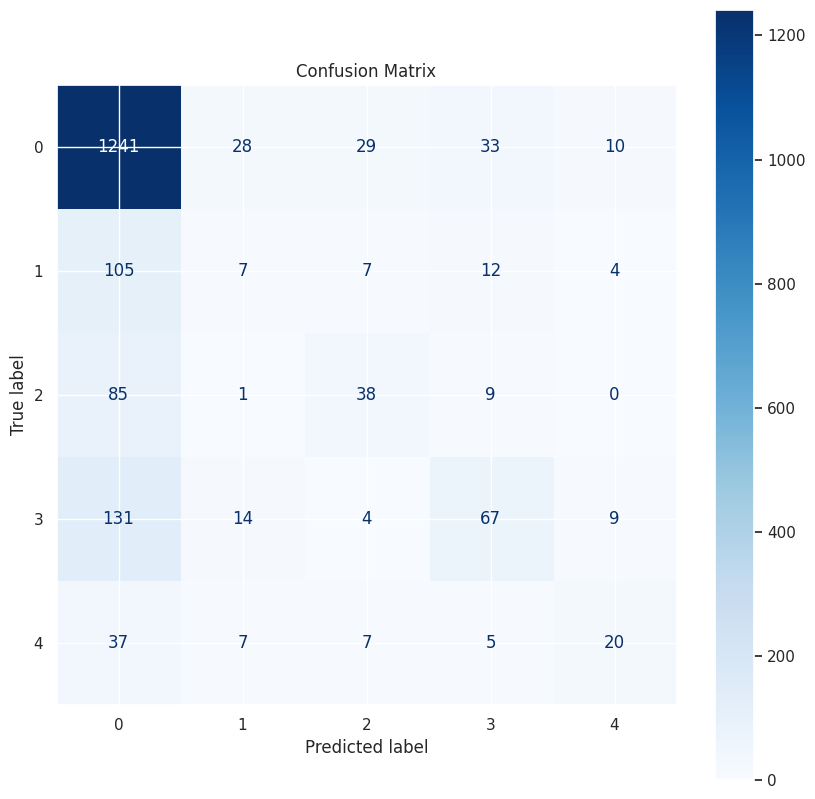

In [57]:
# Prediction 
#'''
# Predict probabilities
test_prob = u_pipe.predict_proba(X_test)

# Binarize the test labels for AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Calculate AUC (One-vs-Rest) for each class individually
individual_aucs = {}
for i, class_label in enumerate(np.unique(y_train)):
    individual_auc = roc_auc_score(y_test_binarized[:, i], test_prob[:, i])
    individual_aucs[class_label] = individual_auc
    print(f"AUC for class {class_label}: {individual_auc}")

# Calculate AUC (One-vs-Rest)
auc_ovr = roc_auc_score(y_test_binarized, test_prob, multi_class='ovr', average='weighted')
print(f"AUC (One-vs-Rest): {auc_ovr}")

# Predict classes for confusion matrix
test_pred = u_pipe.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()#'''
None

## Save Model

In [ ]:
# using joblib
joblib.dump(Txgb, 'xgb_tabular_image_ENet_Old_text_model_1a_Apr_1_F.joblib')

# using pickle
with open('xgb_tabular_image_ENet_Old_text_model_1a_Apr_1_F.pkl', 'wb') as file:
    pickle.dump(Txgb, file)